In [1]:
import dir_constants as dc
from tqdm import tqdm
from j_utils import munging as mg
from j_utils import eval_results as er
from fastai.structured import *

pd.options.display.max_columns = 999
# pd.options.display.max_rows = 999
pd.options.display.max_seq_items = None
# np.set_printoptions(threshold=100)

In [2]:
PATH = dc.data_path
project = 'lendingclub'
fname_base_loan = 'base_loan_info.fth'
fname_eval_loan = 'eval_loan_info.fth'
fname_str_loan = 'str_loan_info.fth'
fname_scl_pmt = 'scaled_pmt_hist.fth'
data_path = f'{PATH}{project}'

In [3]:
base_loan_info = pd.read_feather(f'{data_path}/base_loan_info.fth')
eval_loan_info = pd.read_feather(f'{data_path}/eval_loan_info.fth')
str_loan_info = pd.read_feather(f'{data_path}/str_loan_info.fth')

In [4]:
# if I drop fico range low, does fico range high take on full importance?
base_loan_info.drop('fico_range_low', axis=1, inplace=True)

In [5]:
scaled_pmt_hist = pd.read_feather(f'{data_path}/scaled_pmt_hist.fth')

# cut to done loans before doing EDA, since we don't know default or not about ongoing loans

In [6]:
# get loans that are >= .95 maturity time, maturity paid, or status is in defaulted, charged_off, paid
done_loan_ids = eval_loan_info[(eval_loan_info['maturity_time'] >= .95) |
#                                (eval_loan_info['maturity_paid'] >= .95) |
                               (eval_loan_info['loan_status'].isin(['paid', 'charged_off', 'defaulted']))
                              ]['id'].values

In [7]:
done_loans = base_loan_info[base_loan_info['id'].isin(done_loan_ids)]
done_eval_loans = eval_loan_info[eval_loan_info['id'].isin(done_loan_ids)]

# first of all, do non_money cols change ever over time for a loan?
## No, so just drop all these cols and get it from loan_info instead

In [ ]:
loan_info_overlap_cols = ['addr_state', 'current_policy', 'dq_24m', 'dti', 'emp_len', 'home_ownership', 'int_rate', 'm_income', 'm_since_dq', 'm_since_rec', 'open_credit_lines', 'revol_line_util', 'total_credit_lines', ]

In [ ]:
# id_grouped = scaled_pmt_hist.groupby('id')
# ids_multicol_dict = {}
# for ids, group in tqdm(id_grouped):
#     multi_cols = []
#     for col in non_money_cols:
#         if group[col].nunique() > 1:
#             multi_cols.append(col)
#     if len(multi_cols) > 0:
#         ids_multicol_dict[ids] = multi_cols

In [ ]:
scaled_pmt_hist = scaled_pmt_hist[[col for col in scaled_pmt_hist.columns if col not in loan_info_overlap_cols]]

In [ ]:
scaled_pmt_hist.head()

In [ ]:
# each month if you had your money equally split in every ongoing cohort/vintage of loans, these are your returns
# example: in month 7, there are 3 cohorts. Calculate the returns of 3 cohorts individually, then take the mean
ret_dict = {}
ret_calcs_dict = {}
date_grouped = scaled_pmt_hist.groupby('pmt_date')
for date, group in tqdm(date_grouped):
    iss_d_grouped = group.groupby('issue_d')
    iss_d_rets = []
    date_iss_d_rets_dict = {}
    for iss_d, subgroup in iss_d_grouped:
        iss_d_ret = subgroup['amt_paid'].sum()/group['outs_princp_beg'].sum()
        iss_d_rets.append(iss_d_ret)
        date_iss_d_rets_dict[iss_d] = iss_d_ret
    ret_calcs_dict[date] = date_iss_d_rets_dict
    ret_dict[date] = sum(iss_d_rets)/len(iss_d_rets)

In [ ]:
ret_df = pd.DataFrame.from_dict(ret_dict, orient='index')
plt.plot(ret_df['1-1-2010':])

In [ ]:
# luckily, no return is negative for a month though. But returns look pretty shitty, hence why we need to pick loans more smartly

# working with target_strict, lets get a sense of what might be correlated to target_strict

In [8]:
# base_loan_info['target'] = eval_loan_info['target_strict']
# base_loan_info['addr_zip'] = base_loan_info['addr_zip']

# munging data to turn into numerics or categories/numerics

In [8]:
def transform_dates(df):
    '''
    Looks for datetime columns in the df, uses fastai's add_datepart to turn it
    into several columns (year, day, is quarter end, etc.)
    Does this inplace.
    '''
    date_cols = list(df.select_dtypes('datetime').columns)
    for col in date_cols:
        add_datepart(df, col,)

def remove_zerovar_cols(df, ret_cols=False):
    '''
    Iterates throught columns and checks nunique(). If nunique == 1, then the whole
    column has only one value, and will be dropped inplace. Prints out which
    columns it has dropped and can return them if desired.
    '''
    zerovar_cols = []
    consider_drop_cols = []
    for col in df.columns:
        nunique = df[col].nunique(dropna=False)
        if nunique <= 1:
            zerovar_cols.append(col)
        elif nunique == 2:
            consider_drop_cols.append(col)
    df.drop(zerovar_cols, axis=1, inplace=True)
    print('dropping the following cols: \n{0}'.format(zerovar_cols))
    print('only 2 values, consider dropping the following cols: \n{0}'.format(consider_drop_cols))
    if ret_cols:
        return zerovar_cols, consider_drop_cols

In [9]:
# breakout datetimes into more valuable columns
transform_dates(done_loans)
# delete columns that don't have meaningful variation
zerovar_cols, consider_drop_cols = remove_zerovar_cols(done_loans, ret_cols=True)
drop_cols = ['sec_app_earliest_cr_lineDay', 'sec_app_earliest_cr_lineIs_month_start',]
done_loans.drop(drop_cols, axis=1, inplace=True)
remove_zerovar_cols(done_loans)
# turn str cols into categorical cols
# train_cats(done_loans)

/home/justin/justin_tinkering/fastai/structured.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
/home/justin/justin_tinkering/fastai/structured.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
/home/justin/justin_tinkering/fastai/structured.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

dropping the following cols: 
['sec_app_earliest_cr_lineIs_month_end', 'sec_app_earliest_cr_lineIs_quarter_end', 'sec_app_earliest_cr_lineIs_year_end', 'earliest_cr_lineDay', 'earliest_cr_lineIs_month_end', 'earliest_cr_lineIs_month_start', 'earliest_cr_lineIs_quarter_end', 'earliest_cr_lineIs_year_end']
only 2 values, consider dropping the following cols: 
['term', 'initial_list_status', 'sec_app_earliest_cr_lineDay', 'sec_app_earliest_cr_lineIs_month_start', 'sec_app_earliest_cr_lineIs_quarter_start', 'sec_app_earliest_cr_lineIs_year_start', 'earliest_cr_lineIs_quarter_start', 'earliest_cr_lineIs_year_start']
dropping the following cols: 
[]
only 2 values, consider dropping the following cols: 
['term', 'initial_list_status', 'sec_app_earliest_cr_lineIs_quarter_start', 'sec_app_earliest_cr_lineIs_year_start', 'earliest_cr_lineIs_quarter_start', 'earliest_cr_lineIs_year_start']


In [10]:
def jproc_df(df, target=None, one_hot=False, copy=True, summary=True):
    '''
    Should be run on df after:
    1. mg.transform_dates, (turns datetime columns into ML usable)
    2. mg.remove_zerovar_cols, and consider drop cols is examined
    3. fastai's train_cats (turns obj/str cols into categorical)
    
    This function will convert categoricals to their codes, adding +1 (so nan
    is 0 instead of -1), and then will calculate means/stddev for
    normalizing and median for filling nan values. Also creates new cols
    demarkating whether value was originally nan via
    mg.get_medians_make_nullcols_fill_values.
    
    copy could be set to False if you suspect memory issues
    
    returns x, y, na_dict, mapper
    '''
    
    if target:
        y = df[target]
    else:
        print('No specified target column, assuming target already separated')
        y = []
    if copy:
        df = df.copy()
    
    # deal with cat cols, can either onehot or just turn into the categorical code
    cat_cols = df.select_dtypes('category').columns
    if one_hot:
        print('Turning categoricals into one_hot representation')
        dummied = pd.get_dummies(df[cat_cols])
        df.drop(cat_cols, axis=1, inplace=True)
    else:
        print('Converting categoricals to their codes . . .')
        for col in tqdm(cat_cols):
            df[col] = df[col].cat.codes+1
    
    # all other (numeric) cols
    # gather the means/stddevs/nas __________________
    print('Calculating means/medians/std_devs . . .')
    all_other_cols = [col for col in df.columns if col not in cat_cols]
    mapper = {}
    na_dict = {}
    for col in tqdm(all_other_cols):
        mapper[col] = {'mean': df[col].mean(),
                       'std_dev': df[col].std()}
        na_dict[col] = df[col].median()
        
    # make na cols, fill nas with median
    print('Making _isnull indicator columns . . .')
    has_nulls = [col for col in df.columns if any(df[col].isnull())]
    for col in tqdm(has_nulls):
        df[col+'_isnull'] = np.where(df[col].isnull(), 1, 0)
        df[col] = df[col].fillna(na_dict[col])
        
    # normalize the df excluding cat_cols
    print('Normalizing all non-categorical and non-_isnull columns . . .')
    all_other_cols = [col for col in df.columns if col not in cat_cols]
    for col in tqdm(all_other_cols):
        if '_isnull' not in col:
            df[col] = (df[col]-mapper[col]['mean'])/mapper[col]['std_dev']
    
    if one_hot:
        df = pd.concat([df, dummied], axis=1)
    
    if summary:
        print('Categorical cols: {0}\n\n'.format(list(cat_cols)))
        print('Made _isnull cols for: {0}\n\n'.format(list(has_nulls)))
        print('Normalized all other cols: {0}\n\n'.format([col for col in all_other_cols if '_isnull' not in col]))
            
    return df, y, na_dict, mapper

# prep for eda

In [11]:
null_value_stats = done_loans.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

tot_cur_bal                             70131
num_tl_12_0dpd_2m                       97003
num_accts_ever_12_0_ppd                 70131
num_tl_30dpd                            70131
sec_app_inq_last_6_mths                854672
acc_open_past_24_mths                   49885
inq_last_12m                           701840
mths_since_last_record                 719159
mo_sin_old_il_acct                      94638
mths_since_recent_bc_dlq               658617
sec_app_open_acc                       854672
emp_length                              45379
open_rv_24m                            701840
num_op_rev_tl                           70131
pct_tl_nvr_dlq                          70281
sec_app_open_act_il                    854923
num_bc_tl                               70131
sec_app_fico_range_high                854672
mo_sin_rcnt_rev_tl_op                   70132
sec_app_chargeoff_within_12_mths       854672
revol_util                                519
num_actv_rev_tl                   

In [12]:
done_loans.fillna(-9999, inplace=True)

/home/justin/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [13]:
# make a crude test set for now
def get_split_date(df, date_column, quantile): 

    """
    https://stackoverflow.com/questions/31018622/pandas-quantile-function-for-dates
    Get the date on which to split a dataframe for timeseries splitting
    Adjusted coerce param to errors since SO is old.
    """ 

    # 1. convert date_column to datetime (useful in case it is a string) 
    # 2. convert into int (for sorting) 
    # 3. get the quantile 
    # 4. get the corresponding date
    # 5. return, pray that it works 

    quantile_date = pd.to_datetime(df[date_column], errors = 'raise').astype('int64').quantile(q=quantile)#.astype('datetime64[ns]')

    return pd.to_datetime(quantile_date)

cut_date = get_split_date(done_eval_loans, 'issue_d', .8)

In [14]:
test_ids = done_eval_loans[done_eval_loans['issue_d'] >= cut_date]['id'].values
test_df = done_loans[done_loans['id'].isin(test_ids)]
train_df = done_loans[~done_loans['id'].isin(test_ids)]

In [15]:
print(train_df.shape,test_df.shape)
print("test_df class percentage\n", done_eval_loans[done_eval_loans['id'].isin(test_ids)]['target_strict'].value_counts(dropna=False)/len(test_df))
print("train_df class percentage\n", done_eval_loans[~done_eval_loans['id'].isin(test_ids)]['target_strict'].value_counts(dropna=False)/len(train_df))

(679252, 116) (178330, 116)
test_df class percentage
 0    0.794454
1    0.205546
Name: target_strict, dtype: float64
train_df class percentage
 0    0.793496
1    0.206504
Name: target_strict, dtype: float64


In [16]:
X = train_df
y = eval_loan_info[eval_loan_info['id'].isin(train_df['id'].values)]['target_strict']

# EDA, compare catboost and lightgbm

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import roc_curve, roc_auc_score
import lightgbm as lgb

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

X_test = test_df
y_test = eval_loan_info[eval_loan_info['id'].isin(X_test['id'].values)]['target_strict']

/home/justin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [18]:
def get_feature_importances_and_names(model, data, model_type):
    if model_type=='catboost'.lower():
        feature_importances = model.get_feature_importance(data,) #fstr_type='ShapValues')
        feature_names = data.get_feature_names()
    elif model_type=='lightgbm'.lower():
        feature_importances = lgbm.feature_importance()
        feature_names = data.feature_name
    else:
        print('unknown model_type or not implemeneted yet')
        return None
    
    imps = []
    feat_names = []
    for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
            imps.append(score)
            feat_names.append(name)
    return feat_names, imps

In [19]:
def make_roc_plot(y_true, y_preds):
    '''
    y_true is 1-d array
    y_preds is 1-d array
    makes and shows roc_auc plot
    '''
    fpr, tpr, _ = roc_curve(y_true, y_preds)
    auc_score = roc_auc_score(y_true, y_preds)
    plt.plot(fpr, tpr, color='darkorange', label = 'ROC curve (area = {0})'.format(auc_score) )
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.legend(loc='lower right')
    plt.show()
    
def make_feat_imp_plot(model, model_type, data, n_bar=15, ylim=.75, imp_thrsh=.9,figsize=(12,9)):
    '''
    Makes a plot of feature importances using data
    model = model (sklearn randomforest, lightgbm, or catboost)
    model_type: str; 'sklearn-rf', 'lightgbm', or 'catboost'
    data = pool from catboost, df for others
    top_n = top n features to plot. Default is None which plots all. Can pass float as well and will calculate top_n rounded to nearest int.
    '''
    feat_names, imps = get_feature_importances_and_names(model, data, model_type)

    df = pd.DataFrame.from_dict({'feat': feat_names,
                                    'imps': imps})
    df['norm_imps'] = df['imps']/df['imps'].sum()
    df['cum_imps'] = np.cumsum(df['norm_imps'])
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize)
    ax[0].barh(list(reversed(list(df.index[:n_bar]))), 
            df['norm_imps'].head(n_bar), 
            align = 'center', edgecolor = 'k')
    # Set the yticks and labels
    ax[0].set_yticks(list(reversed(list(df.index[:n_bar]))))
    ax[0].set_yticklabels(df['feat'].head(n_bar))
    ax[0].set_xlabel('Normalized Importance')
    ax[0].set_title('Feature Importances')
    ax[1].plot(list(range(len(df))), df['cum_imps'], 'r-')
    ax[1].set_ylabel('Cumulative Feature Importance')
    ax[1].set_xlabel('Number of Features')
    ax[1].set_title('Cumulative Features')
    ax[1].set_ylim(ylim,1.01)
    fig.tight_layout()
    plt.show()
    
    return df    

## train Catboost

In [20]:
obj_cols = X_train.select_dtypes('object').columns

In [21]:
categorical_features_indices = [X_train.columns.get_loc(col) for col in obj_cols]

In [22]:
params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'eval_metric': 'Accuracy',
#     'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'task_type': 'GPU'
}
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_validation, y_validation, cat_features=categorical_features_indices)

In [23]:
cat_model = CatBoostClassifier(**params)
cat_model.fit(train_pool, eval_set=validate_pool)

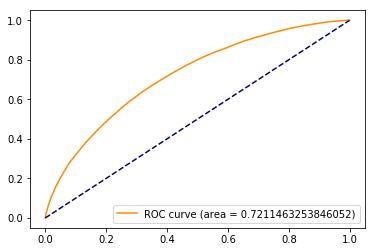

In [24]:
# check roc_auc on validation
# predictions = cat_model.predict(X_validation)
predictions_probs = cat_model.predict_proba(X_validation)
make_roc_plot(y_validation, predictions_probs[:,1])

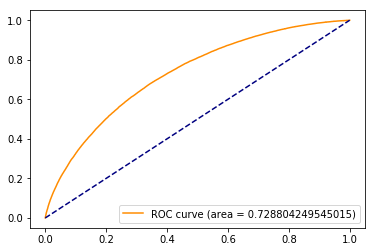

In [25]:
# check roc_auc on test
# predictions = cat_model.predict(X_validation)
predictions_probs = cat_model.predict_proba(X_test)
make_roc_plot(y_test, predictions_probs[:,1])

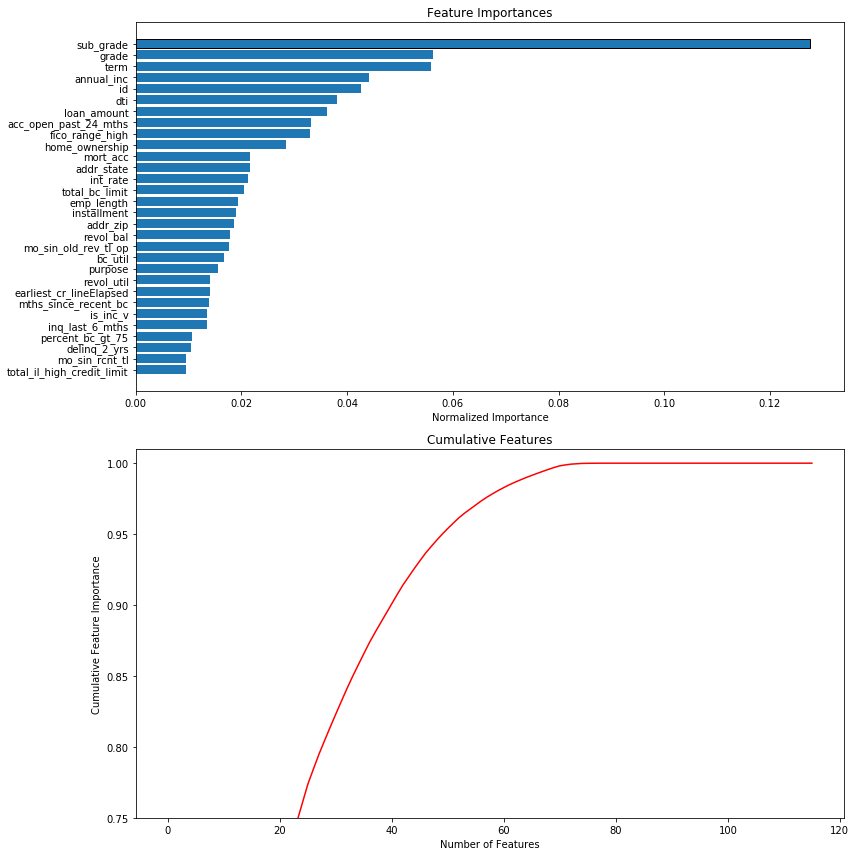

In [26]:
fi_df_catboost = make_feat_imp_plot(cat_model, 'catboost', train_pool, n_bar=30, figsize=(12,12))

# train lightgbm

In [27]:
def obj_to_cats_train(train_df):
    '''
    Input is the training df with object columns. Returns the df with obj cols converted to categorical cols.
    '''
    
    train_df = train_df.copy()
    cat_df = train_df.select_dtypes('object')
    ori_col_order = train_df.columns
    obj_cols = cat_df.columns
    train_df.drop(obj_cols, axis=1, inplace=True)
    coded_df = cat_df.copy()
    for col in obj_cols:
        cat_df[col] = cat_df[col].astype('category')
        coded_df[col] = cat_df[col].cat.codes
    to_ret = pd.concat([train_df, coded_df], axis=1)
    to_ret = to_ret[ori_col_order]
    return to_ret, cat_df

def obj_to_cats_eval(cat_df, eval_df):
    '''
    cat_df to encode eval_df. cat_df is 2nd output of obj_to_cats_train function
    '''
    eval_df = eval_df.copy()
    for col in cat_df.columns:
        eval_df[col] = pd.Categorical(eval_df[col], categories=cat_df[col].cat.categories)
        eval_df[col] = eval_df[col].cat.codes
    return eval_df

In [28]:
# create lgb datasets
lgb_otc_train, train_cat_df = obj_to_cats_train(X_train)
lgb_otc_validation = obj_to_cats_eval(train_cat_df, X_validation)
lgb_otc_test = obj_to_cats_eval(train_cat_df, X_test)

/home/justin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [29]:
(lgb_otc_train.columns == lgb_otc_validation.columns).all()
(lgb_otc_train.columns == lgb_otc_test.columns).all()

True

In [30]:
lgb_train = lgb.Dataset(lgb_otc_train, y_train)
lgb_validation = lgb.Dataset(lgb_otc_validation, y_validation)
# lgb_test = lgb.Dataset(lgb_otc_test, y_test)

In [31]:
cat_col_idx = []
for i,col in enumerate(lgb_otc_train.columns):
    if col in train_cat_df.columns:
        cat_col_idx.append(i)

In [32]:
lgb_otc_train.columns[cat_col_idx]

Index(['application_type', 'emp_length', 'addr_state', 'disbursement_method',
       'is_inc_v_joint', 'grade', 'purpose', 'is_inc_v', 'initial_list_status',
       'addr_zip', 'home_ownership', 'sub_grade'],
      dtype='object')

In [33]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'categorical_feature':cat_col_idx
}

In [34]:
lgbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_validation,
                early_stopping_rounds=100)

/home/justin/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:661: UserWarning: categorical_feature keyword has been found in `params` and will be ignored. Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


[1]	valid_0's auc: 0.68248	valid_0's l2: 0.161623
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.685584	valid_0's l2: 0.160546
[3]	valid_0's auc: 0.690146	valid_0's l2: 0.159507
[4]	valid_0's auc: 0.691701	valid_0's l2: 0.158554
[5]	valid_0's auc: 0.692441	valid_0's l2: 0.157696
[6]	valid_0's auc: 0.693445	valid_0's l2: 0.156933
[7]	valid_0's auc: 0.693832	valid_0's l2: 0.156231
[8]	valid_0's auc: 0.693871	valid_0's l2: 0.155601
[9]	valid_0's auc: 0.694509	valid_0's l2: 0.155002
[10]	valid_0's auc: 0.695122	valid_0's l2: 0.154462
[11]	valid_0's auc: 0.695693	valid_0's l2: 0.153969
[12]	valid_0's auc: 0.696249	valid_0's l2: 0.153501
[13]	valid_0's auc: 0.696675	valid_0's l2: 0.153092
[14]	valid_0's auc: 0.697215	valid_0's l2: 0.152737
[15]	valid_0's auc: 0.697293	valid_0's l2: 0.15241
[16]	valid_0's auc: 0.697497	valid_0's l2: 0.152096
[17]	valid_0's auc: 0.697674	valid_0's l2: 0.151813
[18]	valid_0's auc: 0.697789	valid_0's l2: 0.151553
[19]	valid_0

[159]	valid_0's auc: 0.710617	valid_0's l2: 0.146997
[160]	valid_0's auc: 0.710659	valid_0's l2: 0.146993
[161]	valid_0's auc: 0.710724	valid_0's l2: 0.146983
[162]	valid_0's auc: 0.710728	valid_0's l2: 0.146981
[163]	valid_0's auc: 0.710757	valid_0's l2: 0.146977
[164]	valid_0's auc: 0.710819	valid_0's l2: 0.146967
[165]	valid_0's auc: 0.71083	valid_0's l2: 0.146966
[166]	valid_0's auc: 0.710834	valid_0's l2: 0.146965
[167]	valid_0's auc: 0.710872	valid_0's l2: 0.14696
[168]	valid_0's auc: 0.710869	valid_0's l2: 0.146959
[169]	valid_0's auc: 0.71088	valid_0's l2: 0.14696
[170]	valid_0's auc: 0.710867	valid_0's l2: 0.146961
[171]	valid_0's auc: 0.710865	valid_0's l2: 0.146963
[172]	valid_0's auc: 0.710849	valid_0's l2: 0.146963
[173]	valid_0's auc: 0.710852	valid_0's l2: 0.146962
[174]	valid_0's auc: 0.71083	valid_0's l2: 0.146965
[175]	valid_0's auc: 0.710832	valid_0's l2: 0.146967
[176]	valid_0's auc: 0.710827	valid_0's l2: 0.146966
[177]	valid_0's auc: 0.710836	valid_0's l2: 0.14696

[317]	valid_0's auc: 0.711006	valid_0's l2: 0.147007
Early stopping, best iteration is:
[217]	valid_0's auc: 0.711154	valid_0's l2: 0.146925


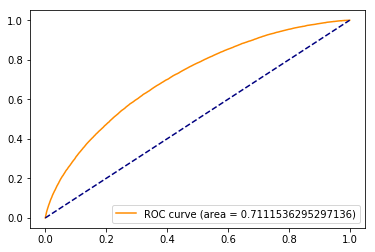

In [35]:
# check roc_auc on validation
predictions_probs = lgbm.predict(lgb_otc_validation)
make_roc_plot(y_validation, predictions_probs)

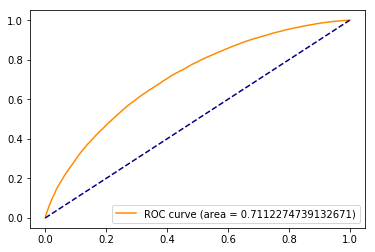

In [36]:
# check roc_auc on validation
predictions_probs = lgbm.predict(lgb_otc_test)
make_roc_plot(y_test, predictions_probs)

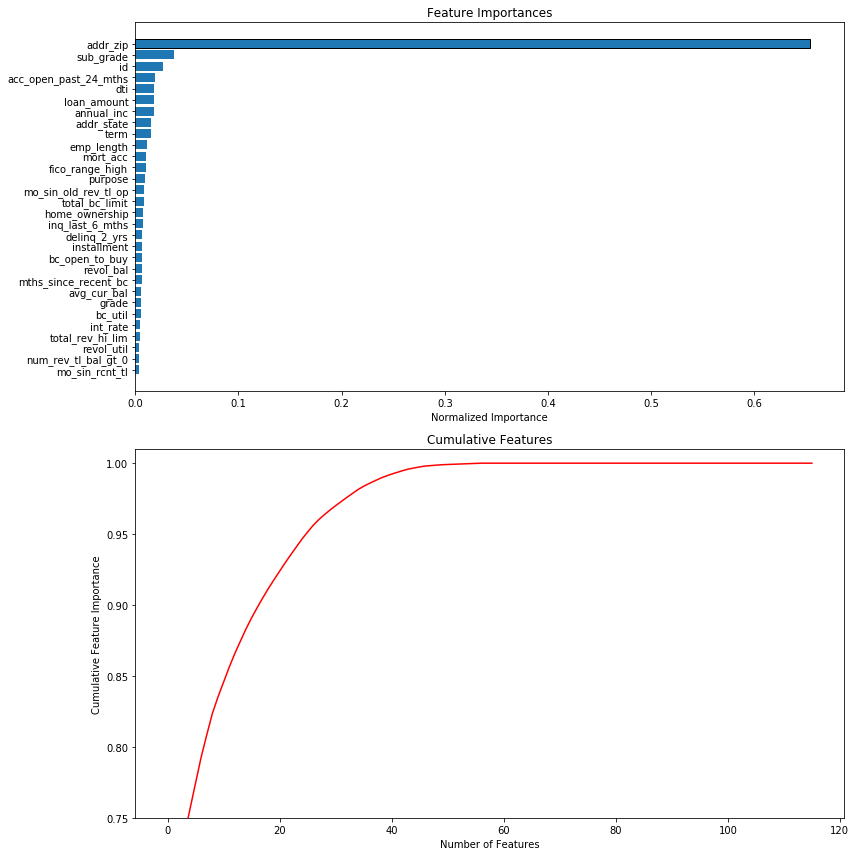

In [37]:
fi_df_lgbm = make_feat_imp_plot(lgbm, 'lightgbm', lgb_train, n_bar=30, figsize=(12,12))

# Shap values

In [38]:
import shap
shap.initjs()

In [39]:
cat_explainer = shap.TreeExplainer(cat_model)
lgbm_explainer = shap.TreeExplainer(lgbm)

In [40]:
cat_shap_values = cat_explainer.shap_values(train_pool)
lgbm_shap_values = lgbm_explainer.shap_values(lgb_otc_train)

The model has complex ctrs, so the SHAP values will be calculated approximately.


In [41]:
n_samp = 100
samp_idx = np.random.choice(len(cat_shap_values), size=n_samp, replace=False)

In [42]:
cat_predictions_probs = cat_model.predict_proba(X_train)
cat_predictions = cat_model.predict(X_train)

In [43]:
# shap.force_plot(cat_explainer.expected_value, cat_shap_values[samp_idx], X_train.iloc[samp_idx,:])

In [44]:
ind_idx = 42
shap.force_plot(cat_explainer.expected_value, cat_shap_values[samp_idx][ind_idx,:], X_train.iloc[samp_idx,:].iloc[ind_idx,:])

In [46]:
# cat_predictions_probs[samp_idx][ind_idx]
# arr = cat_predictions_probs[samp_idx][ind_idx]
# np.exp(-3.29)

In [47]:
# shap.dependence_plot("id", cat_shap_values, lgb_otc_train)

In [48]:
n_samp = 30000
samp_idx = np.random.choice(len(cat_shap_values), size=n_samp, replace=False)

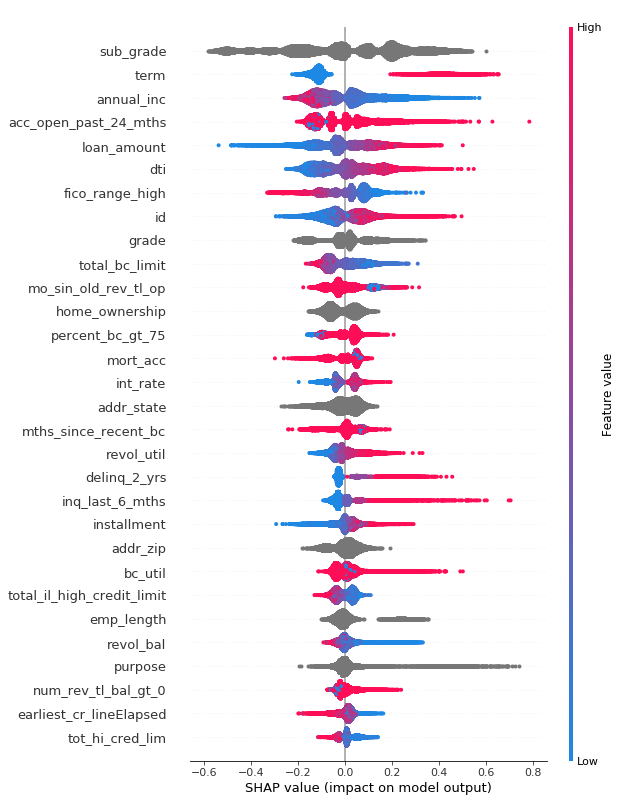

In [49]:
# catboost important 
shap.summary_plot(cat_shap_values[samp_idx], X_train.iloc[samp_idx], max_display=30,)

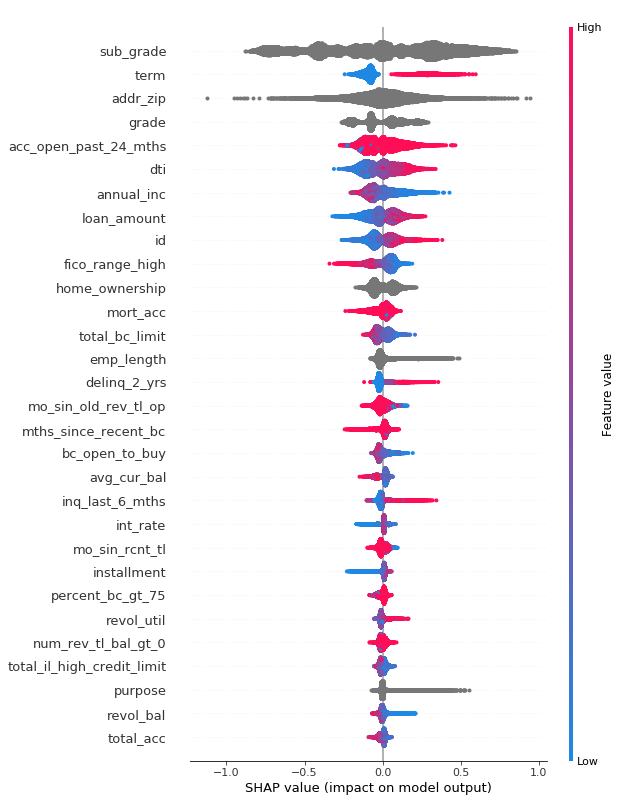

In [50]:
shap.summary_plot(lgbm_shap_values[samp_idx], X_train.iloc[samp_idx], max_display=30)

# PIMP

In [53]:
# I suspect addr_zip is coming up as highest importance because of the problem with feature importance based on counting number of times it splits or gini importance as referenced here (https://academic.oup.com/bioinformatics/article/26/10/1340/193348). Double check feature importance with PIMP method

In [95]:
type(train_pool)

catboost.core.Pool

In [96]:
Pool??

In [97]:
cat_model.get_feature_importance??

In [ ]:
# def get_feature_importances_and_names(model, data, model_type):
#     if model_type=='catboost'.lower():
#         feature_importances = model.get_feature_importance(data)
#         feature_names = data.get_feature_names()
#     elif model_type=='lightgbm'.lower():
#         feature_importances = lgbm.feature_importance()
#         feature_names = data.feature_name
#     else:
#         print('unknown model_type or not implemeneted yet')
#         return None
    
#     imps = []
#     feat_names = []
#     for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
#             imps.append(score)
#             feat_names.append(name)
#     return feat_names, imps

In [92]:
get_feature_importances_and_names(lgbm, lgb_train, 'lightgbm')

(['addr_zip',
  'sub_grade',
  'id',
  'annual_inc',
  'dti',
  'addr_state',
  'loan_amount',
  'acc_open_past_24_mths',
  'term',
  'emp_length',
  'purpose',
  'home_ownership',
  'fico_range_low',
  'installment',
  'int_rate',
  'mort_acc',
  'mo_sin_old_rev_tl_op',
  'inq_last_6_mths',
  'total_bc_limit',
  'avg_cur_bal',
  'mths_since_recent_bc',
  'revol_bal',
  'grade',
  'bc_util',
  'total_il_high_credit_limit',
  'total_rev_hi_lim',
  'num_rev_tl_bal_gt_0',
  'mo_sin_rcnt_tl',
  'revol_util',
  'bc_open_to_buy',
  'delinq_2_yrs',
  'percent_bc_gt_75',
  'total_acc',
  'tot_hi_cred_lim',
  'earliest_cr_lineElapsed',
  'num_actv_bc_tl',
  'mo_sin_old_il_acct',
  'num_actv_rev_tl',
  'mths_since_recent_inq',
  'mths_since_last_record',
  'pub_rec_bankruptcies',
  'mths_since_last_delinq',
  'fico_range_high',
  'earliest_cr_lineYear',
  'num_rev_accts',
  'num_il_tl',
  'num_bc_sats',
  'is_inc_v',
  'tot_cur_bal',
  'num_tl_op_past_12m',
  'mo_sin_rcnt_rev_tl_op',
  'total_ba

In [93]:
get_feature_importances_and_names(cat_model, train_pool, 'catboost')

(['sub_grade',
  'term',
  'grade',
  'id',
  'annual_inc',
  'dti',
  'acc_open_past_24_mths',
  'int_rate',
  'loan_amount',
  'fico_range_low',
  'home_ownership',
  'installment',
  'purpose',
  'addr_state',
  'emp_length',
  'is_inc_v',
  'revol_bal',
  'mo_sin_old_rev_tl_op',
  'mort_acc',
  'mths_since_recent_bc',
  'addr_zip',
  'earliest_cr_lineElapsed',
  'total_bc_limit',
  'inq_last_6_mths',
  'bc_util',
  'avg_cur_bal',
  'revol_util',
  'total_il_high_credit_limit',
  'total_acc',
  'tot_hi_cred_lim',
  'percent_bc_gt_75',
  'mths_since_last_record',
  'mo_sin_old_il_acct',
  'mo_sin_rcnt_tl',
  'total_rev_hi_lim',
  'num_actv_rev_tl',
  'delinq_2_yrs',
  'num_tl_op_past_12m',
  'pct_tl_nvr_dlq',
  'num_rev_tl_bal_gt_0',
  'bc_open_to_buy',
  'mths_since_recent_inq',
  'num_rev_accts',
  'mo_sin_rcnt_rev_tl_op',
  'num_il_tl',
  'num_bc_tl',
  'num_actv_bc_tl',
  'fico_range_high',
  'mths_since_last_delinq',
  'pub_rec_bankruptcies',
  'earliest_cr_lineYear',
  'mths_si

In [ ]:
def PIMP_lgbm(X_train, y_train, s, model, model_type, data):
    '''
    s = number of times to permute response variable (y)
    data = special data type for each model type (catboost=pool, lgb.Dataset)
    '''
    # set variables to match the paper's notation
    P = X_train
    l = y_train
    
    

In [83]:
np.random.seed = 42

In [84]:
np.random.random(2)

array([ 0.25796,  0.69399])

In [40]:
%%time
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=validate_pool)

CPU times: user 1min 15s, sys: 32.2 s, total: 1min 47s
Wall time: 39.2 s


In [41]:
%%time
earlystop_params = params.copy()
earlystop_params.update({
    'od_type': 'Iter',
    'od_wait': 40
})
earlystop_model = CatBoostClassifier(**earlystop_params)
earlystop_model.fit(train_pool, eval_set=validate_pool);

CPU times: user 39.5 s, sys: 13.9 s, total: 53.5 s
Wall time: 16.5 s


In [42]:
print('Simple model tree count: {}'.format(model.tree_count_))
print('Simple model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, model.predict(X_validation))
))
print('')

print('Early-stopped model tree count: {}'.format(earlystop_model.tree_count_))
print('Early-stopped model validation accuracy: {:.4}'.format(
    accuracy_score(y_validation, earlystop_model.predict(X_validation))
))

Simple model tree count: 500
Simple model validation accuracy: 0.8264

Early-stopped model tree count: 177
Early-stopped model validation accuracy: 0.8259


In [43]:
current_params = params.copy()
current_params.update({
    'iterations': 10
})
model = CatBoostClassifier(**current_params).fit(X_train, y_train, categorical_features_indices)
# Get baseline (only with prediction_type='RawFormulaVal')
baseline = model.predict(X_train, prediction_type='RawFormulaVal')
# Fit new model
model.fit(X_train, y_train, categorical_features_indices, baseline=baseline);

In [47]:
model = CatBoostClassifier(iterations=10, random_seed=42, logging_level='Silent', task_type='GPU').fit(train_pool)
ntree_start, ntree_end, eval_period = 3, 9, 2
predictions_iterator = model.staged_predict(validate_pool, 'Probability', ntree_start, ntree_end, eval_period)
for preds, tree_count in zip(predictions_iterator, range(ntree_start, ntree_end, eval_period)):
    print('First class probabilities using the first {} trees: {}'.format(tree_count, preds[:5, 1]))

Learning rate set to 0.5
First class probabilities using the first 3 trees: [ 0.45145  0.46118  0.48875  0.45145  0.46785]
First class probabilities using the first 5 trees: [ 0.44342  0.41995  0.44456  0.45629  0.41745]
First class probabilities using the first 7 trees: [ 0.45365  0.40427  0.47062  0.46765  0.39487]


/home/justin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: generator 'CatBoost._staged_predict' raised StopIteration
  after removing the cwd from sys.path.


In [48]:
model = CatBoostClassifier(iterations=50, random_seed=42, logging_level='Silent', task_type='GPU').fit(train_pool)
feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

Learning rate set to 0.5
term: 16.79683255021069
grade: 11.580175463941956
sub_grade: 9.976510088084364
is_inc_v: 7.519905710810429
id: 4.513394906270556
dti: 4.5033100071821295
acc_open_past_24_mths: 4.1289493045495576
annual_inc: 4.048435616009242
installment: 3.113161607025451
tot_cur_bal: 2.456818120974609
loan_amount: 2.2109000248906594
home_ownership: 2.185399562096125
fico_range_high: 1.9464914358316547
emp_length: 1.8122132123140413
mort_acc: 1.727228365539546
mo_sin_old_rev_tl_op: 1.404979933915236
total_bc_limit: 1.327350348301493
addr_state: 1.2036972148913248
purpose: 1.1776397521947746
revol_bal: 1.1490764385926258
inq_last_6_mths: 1.0738694722686073
mths_since_recent_bc: 1.0351845934664508
bc_util: 0.9919898172056723
total_il_high_credit_limit: 0.8811459255963657
addr_zip: 0.7965982496116378
revol_util: 0.6197927833375273
total_rev_hi_lim: 0.5647149665058402
mths_since_last_record: 0.5566063237012878
delinq_2_yrs: 0.5276702571105449
num_rev_tl_bal_gt_0: 0.5220006474460032

In [39]:
eval_metrics = model.eval_metrics(validate_pool, ['AUC'], plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [63]:
model.eval_metrics??

In [38]:
eval_metrics

NameError: name 'eval_metrics' is not defined

In [50]:
print(eval_metrics['AUC'][:6])

[0.7017919690000723, 0.7066406065097321, 0.7116699286215635, 0.7152092974099552, 0.7172592275155356, 0.7190082978580752]


In [152]:
jul_17_first_mort = 119655.75 + 1000 + 1000 - 19.20 -10.06 - 37.38 - 97.99 - 1882.77

In [154]:
jul_17_first_mort 

119608.34999999999

In [163]:
oct_31_2017_wali_paid_yzj = 119655.75 + 1000 + 1000 - 19.20 -10.06 - 37.38 - 97.99 - 1882.77 + 950 + 900 + 1516.13 + 900 + 950 + 2000 - 1192 + -46.78 - 41.83 - 34.12 - 35.45 - 37.41 - 630.27 - 525.70 - 33.54 -1882.77 + .17 + 1509.00 + 1000 - 1882.77 + .03 + .08 + 1000 + 950 + .03 + .08 + 1000 + 950 #Oct 31 2017 Wali paid YZJ

In [165]:
dec_8_2017_justin_charge_mortg = oct_31_2017_wali_paid_yzj - 19.60 - 81.03 - 1882.77 - 275 - 1882.77 + .03 + .08 + 950 - 1882.77 #Dec 8 2017 Justin CHarged YZJ for mort

In [168]:
feb_12_2018_justin_charge_mortg = dec_8_2017_justin_charge_mortg - 700 - 1 - 55 - 4 + .08 + .03 + 950 - 1882.77 + .08 + .03 - 55.01 - 6.59 + 950 - 1882.77 #feb 12 2018 justin charged yzj for mortgage

In [170]:
may_1_2018_justin_charge_mortg = feb_12_2018_justin_charge_mortg + .08 + .03 + 950 - 1882.77 + 950 + .08 + .03 + 950 + .03 + .08 - 1882.77 #what happened to mort charge in apr 2018? may 1 2018 justin charged morg

In [172]:
sept_13_2018 = may_1_2018_justin_charge_mortg - 10000 - 1882.77 + 900 + 950 - 375.99 + .08 + .04 - 1882.77 - 60 + 950 + .08 + 1950 + .05 +180135.71 + 257.04 - 2088.66 - 42.91 + 950 + 975 +.08 + .05 + 287.87 -18.66 - 2077.74 + .08 + .05 + 975 + 289.06 - 2077.74 # caught up until 9 13 2018

In [177]:
sept_13_2018

286328.22000000003

In [176]:
sept_13_2018-(180969.68 + 16089.54 + 2900.46 + 5001.04) - 10000

71367.50000000003

# old method with fastai, others

In [11]:
X, y, na_dict, mapper = jproc_df(done_loans, one_hot=True)

No specified target column, assuming target already separated
Turning categoricals into one_hot representation
Calculating means/medians/std_devs . . .
100%|██████████| 105/105 [00:00<00:00, 138.28it/s]
Making _isnull indicator columns . . .
100%|██████████| 75/75 [00:00<00:00, 119.97it/s]
Normalizing all non-categorical and non-_isnull columns . . .
100%|██████████| 180/180 [00:00<00:00, 338.87it/s]
Categorical cols: ['application_type', 'emp_length', 'addr_state', 'disbursement_method', 'is_inc_v_joint', 'grade', 'purpose', 'is_inc_v', 'initial_list_status', 'addr_zip', 'home_ownership', 'sub_grade']


Made _isnull cols for: ['tot_cur_bal', 'num_tl_12_0dpd_2m', 'num_accts_ever_12_0_ppd', 'num_tl_30dpd', 'sec_app_inq_last_6_mths', 'acc_open_past_24_mths', 'inq_last_12m', 'mths_since_last_record', 'mo_sin_old_il_acct', 'mths_since_recent_bc_dlq', 'sec_app_open_acc', 'open_rv_24m', 'num_op_rev_tl', 'pct_tl_nvr_dlq', 'sec_app_open_act_il', 'num_bc_tl', 'sec_app_fico_range_high', 'mo_sin_

In [12]:
X['target'] = eval_loan_info[eval_loan_info['id'].isin(done_loan_ids)]['target_strict']

In [13]:
X['target'].value_counts(dropna=False)

0    702001
1    156823
Name: target, dtype: int64

In [14]:
eval_loan_info['loan_status'].value_counts(dropna=True)

current        1197415
paid            602055
charged_off     149565
late_120         26418
grace_15         21070
late_30           7067
defaulted          325
Name: loan_status, dtype: int64

In [15]:
corrs = X.corr()

In [16]:
cor_targ = corrs['target'].sort_values(ascending=True)

In [17]:
cor_targ.to_pickle(f'{data_path}/done_loans_dummy_corr_target_strict.pkl')

In [18]:
cor_targ.dropna(inplace=True)

In [19]:
# least correlated 20

print('least correlated__________________\n', cor_targ[:20])
print('most correlated__________________\n', cor_targ[-20:])

least correlated__________________
 grade_A                    -0.149800
fico_range_low             -0.130366
fico_range_high            -0.130365
grade_B                    -0.103978
bc_open_to_buy             -0.079578
avg_cur_bal                -0.070218
tot_hi_cred_lim            -0.069699
total_bc_limit             -0.067701
sub_grade_A1               -0.067350
sub_grade_A4               -0.063750
sub_grade_A5               -0.062220
tot_cur_bal                -0.062196
mort_acc                   -0.061532
home_ownership_mortgage    -0.060920
sub_grade_A2               -0.060148
sub_grade_A3               -0.058702
disbursement_method_Cash   -0.055989
mo_sin_rcnt_tl             -0.054267
sub_grade_B1               -0.054255
sub_grade_B2               -0.050641
Name: target, dtype: float64
most correlated__________________
 sub_grade_E2             0.058657
grade_G                  0.058935
home_ownership_rent      0.059289
is_inc_v_platform        0.061280
loan_amount             

In [20]:
# correlations look weak. Use lgbm and random_forest_classifier to get feature importances for more info
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier, RandomTreesEmbedding

y = X['target']
X.drop('target', axis=1, inplace=True)

In [26]:
set_rf_samples(50000)
clf = RandomForestClassifier(n_estimators = 50, random_state=0, max_depth=20, verbose=True)

In [30]:
clf.fit(X, y)

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   29.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=True,
            warm_start=False)

In [34]:
fi = rf_feat_importance(clf, X); fi[:30]

,cols,imp
2,int_rate,0.044125
18,term,0.025882
59,dti,0.022119
44,id,0.020900
75,loan_amount,0.017024
8,installment,0.016514
82,annual_inc,0.015798
9,fico_range_low,0.015642
34,tot_hi_cred_lim,0.015208
27,revol_util,0.014930


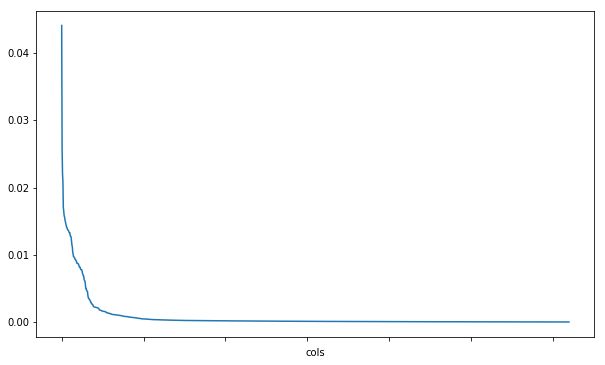

In [35]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [31]:
import j_utils.eval_results as er

In [ ]:
er.